In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import utils
import preprocessing

In [3]:
df = utils.feature_engineering(utils.get_data())

In [4]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=27)

In [25]:
pca = PCA()
scaler = MinMaxScaler(feature_range=(0,1))

X_train = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [26]:
np.cumsum(pca.explained_variance_ratio_)

array([0.14992892, 0.21673695, 0.28247612, 0.34409664, 0.3913932 ,
       0.43675049, 0.47895379, 0.51559625, 0.54903663, 0.5773459 ,
       0.60433116, 0.6297307 , 0.65292694, 0.6748618 , 0.69570912,
       0.71506207, 0.73418215, 0.75198713, 0.76917763, 0.78415143,
       0.7970272 , 0.80980622, 0.82251915, 0.83413289, 0.84565238,
       0.85708062, 0.86833038, 0.87835416, 0.88753672, 0.89661359,
       0.9056595 , 0.91455654, 0.92175991, 0.92856523, 0.93435835,
       0.93939987, 0.9427868 , 0.94595361, 0.94894556, 0.95184817,
       0.95456613, 0.95716984, 0.95975959, 0.96210425, 0.9644342 ,
       0.96640207, 0.96829667, 0.97010926, 0.97191125, 0.97369026,
       0.97532763, 0.97687773, 0.97838688, 0.97986333, 0.98117729,
       0.98243461, 0.9836735 , 0.984906  , 0.98613183, 0.98718079,
       0.98816686, 0.98913818, 0.98987421, 0.99059855, 0.99130005,
       0.99199242, 0.99263477, 0.99325521, 0.99387088, 0.99447386,
       0.99505022, 0.99561833, 0.99612848, 0.9966253 , 0.99707

In [64]:
for i in np.linspace(0.70, 0.95, 6):
    n = np.argmax(np.cumsum(pca.explained_variance_ratio_) > round(i, 2))
    print("Cantidad necesaria para explicar " + str(round(i, 2)) + "\tes " + str(n))

Cantidad necesaria para explicar 0.7	es 15
Cantidad necesaria para explicar 0.75	es 17
Cantidad necesaria para explicar 0.8	es 21
Cantidad necesaria para explicar 0.85	es 25
Cantidad necesaria para explicar 0.9	es 30
Cantidad necesaria para explicar 0.95	es 39


### 70% de la varianza

Se alcanza con 15 variables de PCA.

In [67]:
pca = PCA(15)
scaler = MinMaxScaler(feature_range=(0,1))

X_train70 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test70 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

#### Veamos cómo se comportó la transformación en una dimensión menor, para ello usaremos t-SNE

In [68]:
X_tsne = TSNE(n_components=2, perplexity=100, learning_rate=400, n_iter_without_progress=500, n_jobs=6, verbose=4).fit_transform(X_train70)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.055s...
[t-SNE] Computed neighbors for 24420 samples in 3.941s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for sa

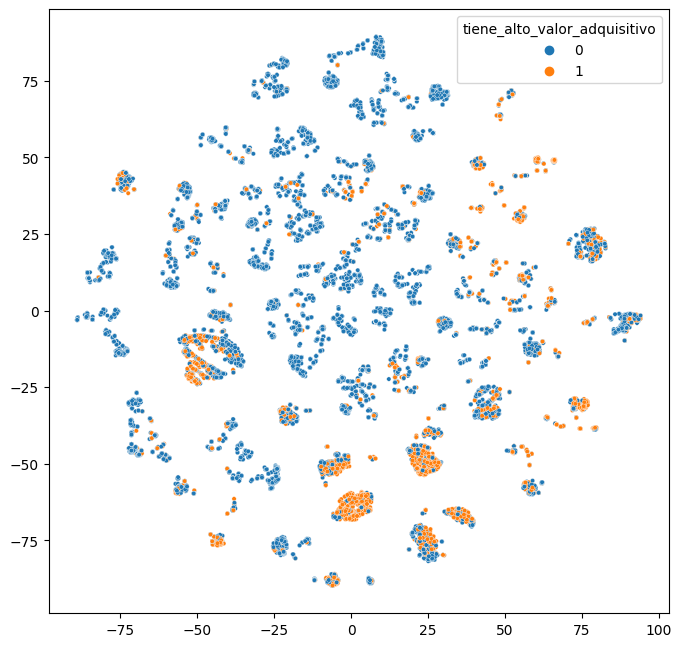

In [70]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=10
)

plt.show()

Viendo el resultado de TSNE parecen haber pequeños clusters, por lo que, KNN podría funcionar correctamente. Veamos:

In [145]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,21),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}
gscv70 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=6, verbose=4)

In [87]:
gscv70.fit(X_train70, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    7.3s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   46.9s
[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 800 out of 800 | elapsed:  4.8min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 21), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [92]:
print(gscv70.best_estimator_)
print(gscv70.best_params_)
print(gscv70.best_score_)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=18)
{'algorithm': 'ball_tree', 'n_neighbors': 18, 'p': 2, 'weights': 'uniform'}
0.8295249795249795


In [95]:
print(classification_report(y_test,gscv70.predict(X_test70)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90      6186
           1       0.71      0.54      0.61      1955

    accuracy                           0.83      8141
   macro avg       0.78      0.73      0.75      8141
weighted avg       0.83      0.83      0.83      8141



Un accuracy decente para test. Veamos qué más se puede obtener

### 75% de la varianza

Se alcanza con 17 variables de PCA.

In [97]:
pca = PCA(17)
scaler = MinMaxScaler(feature_range=(0,1))

X_train75 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test75 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

Veamos si TSNE nos dice algo:

In [99]:
X_tsne = TSNE(n_components=2, perplexity=100, learning_rate=400, n_iter_without_progress=500, n_jobs=6, verbose=4).fit_transform(X_train75)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.058s...
[t-SNE] Computed neighbors for 24420 samples in 4.630s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for sa

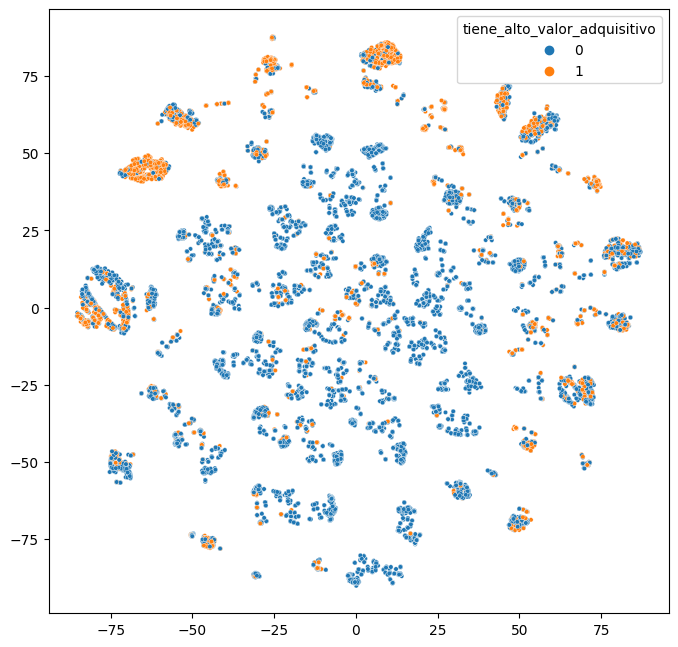

In [102]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=10
)

plt.show()

Parece haber una buena separación, veamos qué hace KNN

In [103]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,21),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}
gscv75 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=6, verbose=4)

In [104]:
gscv75.fit(X_train75, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   10.3s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 800 out of 800 | elapsed:  6.3min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 21), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [106]:
print(gscv75.best_estimator_)
print(gscv75.best_params_)
print(gscv75.best_score_)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=20)
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}
0.8303439803439803


In [108]:
print(classification_report(y_test,gscv75.predict(X_test75)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6186
           1       0.71      0.53      0.61      1955

    accuracy                           0.83      8141
   macro avg       0.78      0.73      0.75      8141
weighted avg       0.82      0.83      0.83      8141



Vemos que la predicción fue similar a la anteriormente obtenida.

### 80% de la varianza

In [109]:
pca = PCA(21)
scaler = MinMaxScaler(feature_range=(0,1))

X_train80 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test80 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [111]:
X_tsne = TSNE(n_components=2, perplexity=100, learning_rate=400, n_iter_without_progress=500, n_jobs=6, verbose=4).fit_transform(X_train80)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.074s...
[t-SNE] Computed neighbors for 24420 samples in 4.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for sa

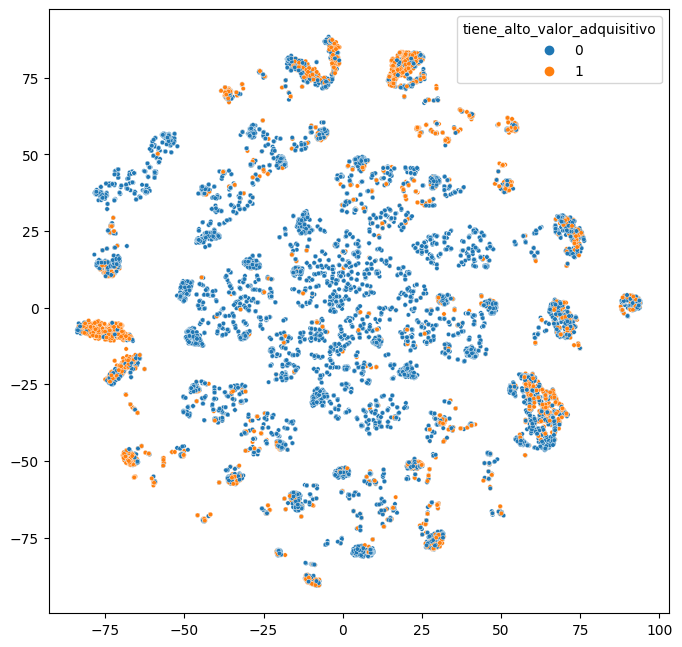

In [113]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=10
)

plt.show()

El resultado parece ser similar a lo previamente observado...

In [114]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,41),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}
gscv80 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=6, verbose=4)

In [115]:
gscv80.fit(X_train80, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   15.9s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 1189 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 1600 out of 1600 | elapsed: 21.2min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 41), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [116]:
print(gscv80.best_estimator_)
print(gscv80.best_params_)
print(gscv80.best_score_)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=29, p=1)
{'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}
0.8304258804258804


In [118]:
print(classification_report(y_test,gscv80.predict(X_test80)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      6186
           1       0.69      0.56      0.62      1955

    accuracy                           0.84      8141
   macro avg       0.78      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141



Bastante similar

Veamos rápidamente qué sucede realizando búsquedas similares con las divisiones que faltan:

In [120]:
pca = PCA(25)
scaler = MinMaxScaler(feature_range=(0,1))

X_train85 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test85 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

pca = PCA(30)
scaler = MinMaxScaler(feature_range=(0,1))

X_train90 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test90 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

pca = PCA(39)
scaler = MinMaxScaler(feature_range=(0,1))

X_train95 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test95 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [121]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,41),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}

gscv85 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=6, verbose=4)
gscv90 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=6, verbose=4)
gscv95 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=6, verbose=4)

In [122]:
gscv85.fit(X_train85, y_train)
gscv90.fit(X_train90, y_train)
gscv95.fit(X_train95, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   24.9s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 1189 tasks      | elapsed: 26.8min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 30.4min
[Parallel(n_jobs=6)]: Done 1600 out of 1600 | elapsed: 30.8min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   26.9s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed: 30.3min
[Parallel(n_jobs=6)]: Done 1189 tasks      | elapsed: 33.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 39.1min
[Parallel(n_jobs=6)]: Done 1600 out of 1600 | elapsed: 39.8min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   46.6s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed: 31.5min
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed: 43.1min
[Parallel(n_jobs=6)]: Done 1189 tasks      | elapsed: 49.4min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 59.5min
[Parallel(n_jobs=6)]: Done 1600 out of 1600 | elapsed: 60.8min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 41), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [124]:
print("Modelo 85%")
print(gscv85.best_estimator_)
print(gscv85.best_params_)
print(gscv85.best_score_)

print("Modelo 90%")
print(gscv90.best_estimator_)
print(gscv90.best_params_)
print(gscv90.best_score_)

print("Modelo 95%")
print(gscv95.best_estimator_)
print(gscv95.best_params_)
print(gscv95.best_score_)

Modelo 85%
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=38, p=1)
{'algorithm': 'ball_tree', 'n_neighbors': 38, 'p': 1, 'weights': 'uniform'}
0.8303030303030303
Modelo 90%
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=36, p=1)
{'algorithm': 'ball_tree', 'n_neighbors': 36, 'p': 1, 'weights': 'uniform'}
0.8291973791973792
Modelo 95%
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=27)
{'algorithm': 'ball_tree', 'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}
0.8353398853398855


In [125]:
print(classification_report(y_test,gscv85.predict(X_test85)))
print("\n\n")
print(classification_report(y_test,gscv90.predict(X_test90)))
print("\n\n")
print(classification_report(y_test,gscv95.predict(X_test95)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6186
           1       0.69      0.54      0.61      1955

    accuracy                           0.83      8141
   macro avg       0.78      0.73      0.75      8141
weighted avg       0.82      0.83      0.83      8141




              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6186
           1       0.69      0.54      0.60      1955

    accuracy                           0.83      8141
   macro avg       0.78      0.73      0.75      8141
weighted avg       0.82      0.83      0.82      8141




              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6186
           1       0.70      0.56      0.62      1955

    accuracy                           0.84      8141
   macro avg       0.79      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141



### Veamos menos varianza explicada.

In [133]:
for i in np.linspace(0.15, 0.50, 8):
    n = np.argmax(np.cumsum(pca.explained_variance_ratio_) > round(i, 2))
    print("Cantidad necesaria para explicar " + str(round(i, 2)) + "\tes " + str(n))

Cantidad necesaria para explicar 0.15	es 1
Cantidad necesaria para explicar 0.2	es 1
Cantidad necesaria para explicar 0.25	es 2
Cantidad necesaria para explicar 0.3	es 3
Cantidad necesaria para explicar 0.35	es 4
Cantidad necesaria para explicar 0.4	es 5
Cantidad necesaria para explicar 0.45	es 6
Cantidad necesaria para explicar 0.5	es 7


In [134]:
pca = PCA(2)
scaler = MinMaxScaler(feature_range=(0,1))

X_train25 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test25 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [135]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,41),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}

gscv25 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=6, verbose=4)

In [136]:
gscv25.fit(X_train25, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed:   14.5s
[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed:   26.7s
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed:   40.3s
[Parallel(n_jobs=6)]: Done 1189 tasks      | elapsed:   50.0s
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1600 out of 1600 | elapsed:  1.1min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 41), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [139]:
print("Modelo 25%")
print(gscv25.best_estimator_)
print(gscv25.best_params_)
print(gscv25.best_score_)

Modelo 25%
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=40)
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}
0.8170352170352171


In [138]:
print(classification_report(y_test,gscv25.predict(X_test25)))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      6186
           1       0.68      0.50      0.57      1955

    accuracy                           0.82      8141
   macro avg       0.77      0.71      0.73      8141
weighted avg       0.81      0.82      0.81      8141



### 40% de la varianza explicada

In [140]:
pca = PCA(5)
scaler = MinMaxScaler(feature_range=(0,1))

X_train40 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test40 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [141]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,41),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}

gscv40 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=6, verbose=4)

In [142]:
gscv40.fit(X_train40, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed:   18.0s
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed:   34.4s
[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 1189 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 1600 out of 1600 | elapsed:  2.3min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 41), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [143]:
print("Modelo 25%")
print(gscv40.best_estimator_)
print(gscv40.best_params_)
print(gscv40.best_score_)

Modelo 25%
KNeighborsClassifier(algorithm='kd_tree', n_neighbors=36, p=1)
{'algorithm': 'kd_tree', 'n_neighbors': 36, 'p': 1, 'weights': 'uniform'}
0.8278050778050778


In [144]:
print(classification_report(y_test,gscv40.predict(X_test40)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6186
           1       0.68      0.52      0.59      1955

    accuracy                           0.83      8141
   macro avg       0.77      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141

